# Computing Plankton Index

In [57]:
import numpy as np
import scipy as sp
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.dates import DateFormatter


### Importing MVCO data

In [2]:

df = pd.read_csv('/D/MIT-WHOI/data/2021/biovol_concentration_by_class_time_seriesCNN_hourly.csv')
df["id"] = df.index

print(df.head())
# print(list(df.columns))

df_filtered =pd.melt(df,id_vars = ['datetime'], var_name = 'species',value_name='biovol/mL')

               datetime  Acanthoica_quattrospina  Akashiwo  \
0  06-Jun-2006 18:56:16                 0.000000       0.0   
1  06-Jun-2006 19:18:01                 0.000000       0.0   
2  06-Jun-2006 20:23:16                 0.000000       0.0   
3  06-Jun-2006 21:17:32                 0.000000       0.0   
4  06-Jun-2006 22:25:43                34.815354       0.0   

   Alexandrium_catenella  Amphidinium  Amylax  Apedinella  \
0                    0.0          0.0     0.0    0.000000   
1                    0.0          0.0     0.0    0.000000   
2                    0.0          0.0     0.0    0.000000   
3                    0.0          0.0     0.0    0.000000   
4                    0.0          0.0     0.0   96.448108   

   Asterionellopsis_glacialis  Bacillaria  Bacillariophyceae  ...     pennate  \
0                  190.513016         0.0         311.643280  ...    0.000000   
1                    0.000000         0.0          56.404548  ...  361.366141   
2                

In [3]:
clist = pd.read_csv('/D/MIT-WHOI/data/2021/IFCB_classlist_type.csv') #importing 

clist = pd.melt(clist,id_vars = ['CNN_classlist'], var_name = 'group',value_name='in_out')

clist_filtered = clist[clist['in_out']==1]

clist_filtered = clist_filtered.rename(columns = {"CNN_classlist":'species','in_out':'present'})

print(clist_filtered.head())

merged = df_filtered.join(clist_filtered.set_index('species'),on = 'species')

print(merged.head())

                                        species   group  present
0                       Chaetoceros_tenuissimus  Diatom      1.0
1                             Cylindrotheca_min  Diatom      1.0
2                          Eucampia_morphytype1  Diatom      1.0
3  Guinardia_delicatula_TAG_Amphidinium_grazing  Diatom      1.0
4                        Hemiaulus_membranaceus  Diatom      1.0
               datetime                  species  biovol/mL            group  \
0  06-Jun-2006 18:56:16  Acanthoica_quattrospina        0.0  Coccolithophore   
0  06-Jun-2006 18:56:16  Acanthoica_quattrospina        0.0             Nano   
1  06-Jun-2006 19:18:01  Acanthoica_quattrospina        0.0  Coccolithophore   
1  06-Jun-2006 19:18:01  Acanthoica_quattrospina        0.0             Nano   
2  06-Jun-2006 20:23:16  Acanthoica_quattrospina        0.0  Coccolithophore   

   present  
0      1.0  
0      1.0  
1      1.0  
1      1.0  
2      1.0  


In [4]:
df_long = merged[['datetime','group','biovol/mL']]

df_short = df_long.pivot_table(index=["datetime"], 
                    columns='group', 
                    values='biovol/mL')

In [5]:
df_short.head()

df_short.index.name = 'datetime'
df_short.reset_index(inplace=True)

In [26]:

df_short['datetime'].head()

df_short['datetime'] =  pd.to_datetime(df_short['datetime'], format="%d-%b-%Y %X")



year = pd.to_numeric(df_short["datetime"].dt.year)
doy = pd.to_numeric(df_short["datetime"].dt.dayofyear).div(365)

df_short["yearday"] = year + doy

df_short['year'] = pd.DatetimeIndex(df_short['datetime']).year
df_short['month'] = pd.DatetimeIndex(df_short['datetime']).month


print(df_short.head())

df_dd = df_short[["year","Diatom","Dinoflagellate","Nano","Ciliate","Coccolithophore"]]

df_dd.to_csv('/D/MIT-WHOI/github_repos/plankton-index/df_dd.txt',sep= " ",index = False)

group            datetime      Ciliate  Coccolithophore        Diatom  \
0     2007-04-01 00:28:14  1952.162094       128.998273  30550.985713   
1     2007-04-01 01:22:34  1888.968813        89.118841  27507.200308   
2     2007-04-01 02:27:47  2734.251767       219.056383  25738.830229   
3     2007-04-01 03:33:02  1506.973968        73.365809  31687.382353   
4     2007-04-01 04:27:21  2232.721254        82.716600  29088.064968   

group  Dinoflagellate  IFCB artifact         Nano    Other live  \
0         2599.249141     670.644834  7367.429339    453.713189   
1         3102.500260     565.436912  8360.338310  25927.564471   
2         2365.043237     897.389025  8509.690338    832.300632   
3         2894.457052    2653.760872  8237.828202   8212.188449   
4         2810.684279     485.804170  8505.711531    267.929262   

group  Other not alive   flagellate  pennatediatom      yearday  year  month  
0          5210.114861  9417.239577    8072.702143  2007.249315  2007      4  


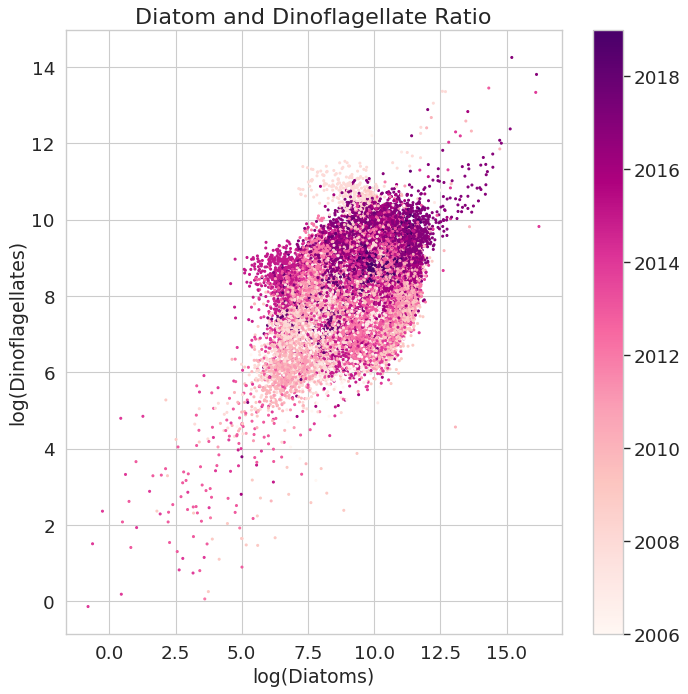

In [61]:
from matplotlib.pyplot import figure
from scipy.stats import gaussian_kde #req'd for density dot plot

figure(figsize=(10, 10), dpi=80) 

plt.scatter(np.log(df_short['Diatom']),
            np.log(df_short['Dinoflagellate']),
            c=df_short["year"],
           cmap = "RdPu",
           s = 3)
plt.colorbar()
plt.xlabel("log(Diatoms)",size = 17)
plt.ylabel("log(Dinoflagellates)",size = 17)
plt.title("Diatom and Dinoflagellate Ratio",size = 20)

sns.set(font_scale=1.5, style="whitegrid")

Text(0.5, 1.0, 'Diatom and Nano Ratio by Month of The Year')

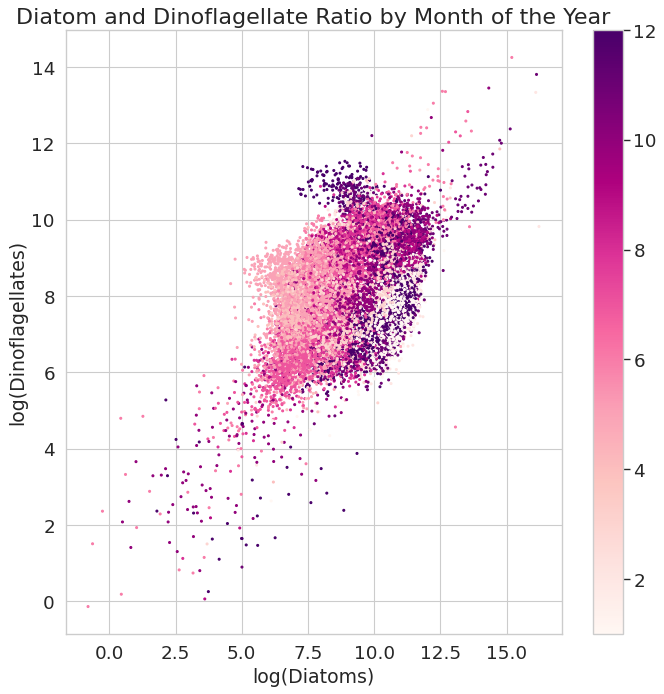

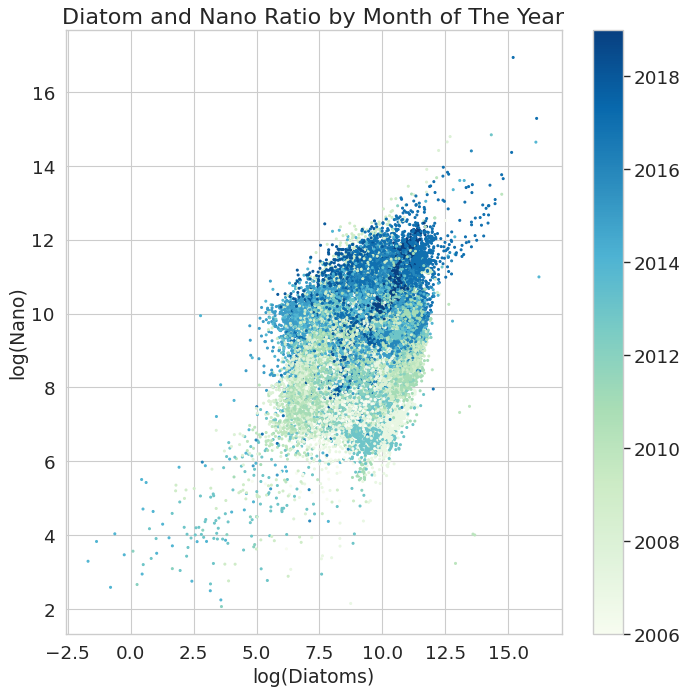

In [67]:
from matplotlib.pyplot import figure
from scipy.stats import gaussian_kde #req'd for density dot plot

figure(figsize=(10, 10), dpi=80) 

plt.scatter(np.log(df_short['Diatom']),
            np.log(df_short['Dinoflagellate']),
            c=df_short["month"],
           cmap = "RdPu",
           s = 3)
plt.colorbar()
plt.xlabel("log(Diatoms)",size = 17)
plt.ylabel("log(Dinoflagellates)",size = 17)
plt.title("Diatom and Dinoflagellate Ratio by Month of the Year",size = 20)

from matplotlib.pyplot import figure
from scipy.stats import gaussian_kde #req'd for density dot plot

figure(figsize=(10, 10), dpi=80) 

plt.scatter(np.log(df_short['Diatom']),
            np.log(df_short['Nano']),
            c=df_short["year"],
           cmap = "GnBu",
           s = 3)
plt.colorbar()
plt.xlabel("log(Diatoms)",size = 17)
plt.ylabel("log(Nano)",size = 17)
plt.title("Diatom and Nano Ratio by Month of The Year",size = 20)

Text(0.5, 1.0, 'Diatom and Nano Ratio by Month of The Year')

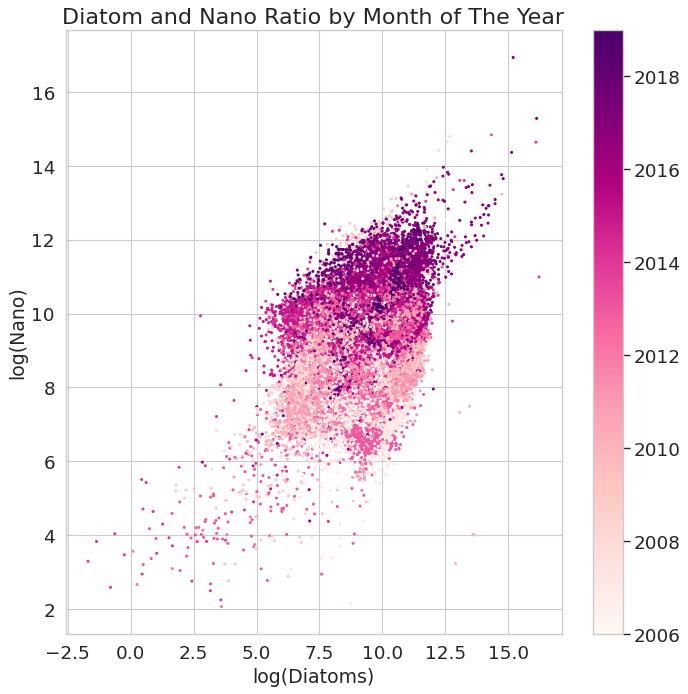

In [59]:
from matplotlib.pyplot import figure
from scipy.stats import gaussian_kde #req'd for density dot plot

figure(figsize=(10, 10), dpi=80) 

plt.scatter(np.log(df_short['Diatom']),
            np.log(df_short['Nano']),
            c=df_short["year"],
           cmap = "RdPu",
           s = 3)
plt.colorbar()
plt.xlabel("log(Diatoms)",size = 17)
plt.ylabel("log(Nano)",size = 17)
plt.title("Diatom and Nano Ratio by Month of The Year",size = 20)

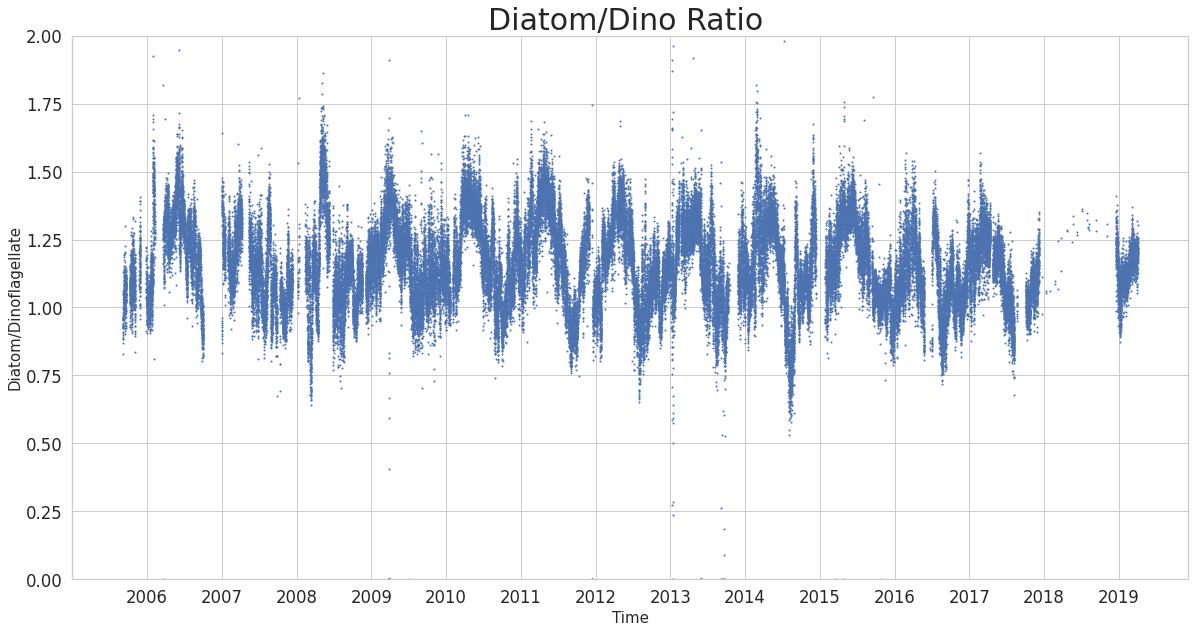

In [58]:
import matplotlib.dates as mdates


fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(df_short["datetime"],
            np.log(df_short["Diatom"])/np.log(df_short["Dinoflagellate"])
           ,s= 1)

fmt_half_year = mdates.MonthLocator(interval=12)
ax.xaxis.set_major_locator(fmt_half_year)

plt.xlabel("Time",size = 15)
plt.ylabel("Diatom/Dinoflagellate",size = 15)
plt.ylim((0,2))
plt.title("Diatom/Dino Ratio ",size = 30)

date_form = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_form)


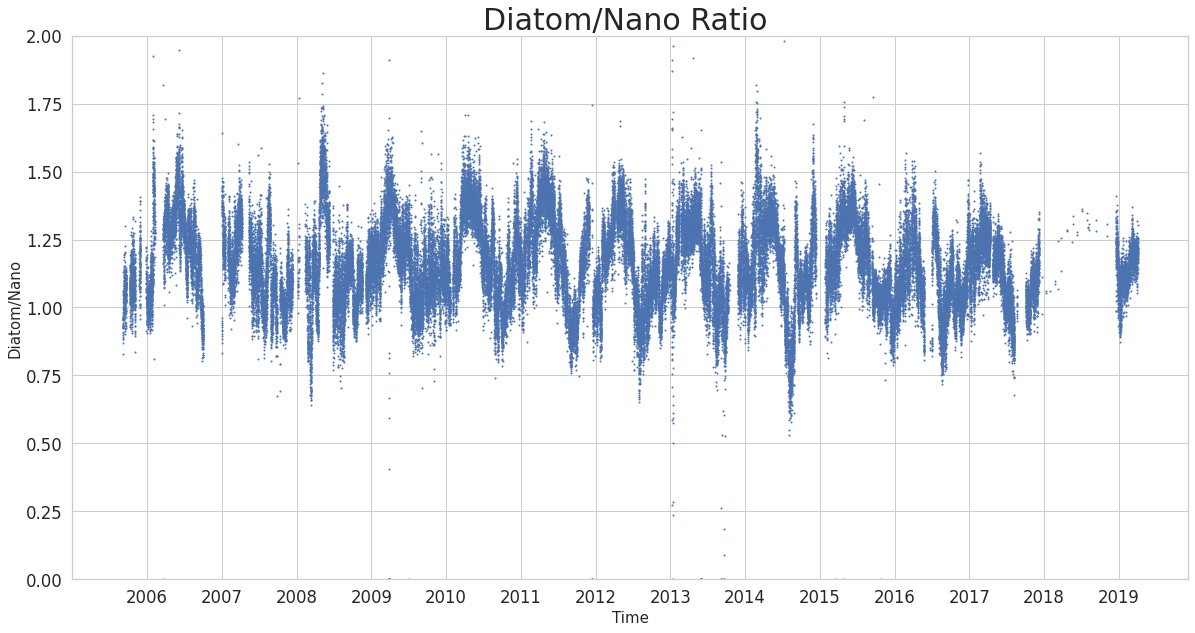

In [65]:
import matplotlib.dates as mdates


fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(df_short["datetime"],
            np.log(df_short["Diatom"])/np.log(df_short["Dinoflagellate"])
           ,s= 1)

fmt_half_year = mdates.MonthLocator(interval=12)
ax.xaxis.set_major_locator(fmt_half_year)

plt.xlabel("Time",size = 15)
plt.ylabel("Diatom/Nano",size = 15)
plt.ylim((0,2))
plt.title("Diatom/Nano Ratio ",size = 30)

date_form = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_form)
